In [99]:
import random
import heapq
import time
import tracemalloc
import gc
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

DEFAULT_SEED = 42
random.seed(DEFAULT_SEED)
np.random.seed(DEFAULT_SEED)


# Graph Preparation

In [100]:
def generate_random_graph(n, edge_prob, min_weight, max_weight):
    graph = defaultdict(list)

    for u in range(1, n):
        parent = random.randint(0, u - 1)
        weight = random.randint(min_weight, max_weight)
        graph[parent].append((u, weight))
        graph[u].append((parent, weight))

    for u in range(n):
        for v in range(n):
            if u != v and random.random() < edge_prob:
                weight = random.randint(min_weight, max_weight)
                graph[u].append((v, weight))

    return dict(graph)

# Build Algorithms

In [101]:
# ============= DIAL'S ALGORITHM =============
def extract_path(parents, dist, source, target):
    if target is None:
        return None
    if target < 0 or target >= len(parents):
        raise ValueError("target index is out of bounds")
    if dist[target] == float('inf'):
        return []
    path = []
    current = target
    while current != -1:
        path.append(current)
        if current == source:
            path.reverse()
            return path
        current = parents[current]
    return []


class DialAlgorithm:
    def __init__(self, n, max_weight):
        self.n = n
        self.max_weight = max_weight
        self.max_dist = max_weight * (n - 1)

    def dijkstra(self, graph, source, target=None):
        self.buckets = [[] for _ in range(self.max_dist + 1)]
        dist = [float('inf')] * self.n
        parents = [-1] * self.n
        visited = [False] * self.n
        dist[source] = 0
        parents[source] = source
        self.buckets[0].append(source)

        idx = 0
        while idx <= self.max_dist:
            while idx <= self.max_dist and not self.buckets[idx]:
                idx += 1
            if idx > self.max_dist:
                break

            while self.buckets[idx]:
                u = self.buckets[idx].pop()

                if visited[u]:
                    continue
                visited[u] = True

                for v, weight in graph.get(u, []):
                    new_dist = dist[u] + weight
                    if new_dist < dist[v]:
                        dist[v] = new_dist
                        parents[v] = u
                        if new_dist <= self.max_dist:
                            self.buckets[new_dist].append(v)

        if target is None:
            return dist
        return dist, extract_path(parents, dist, source, target)


In [102]:
# ============= BINARY HEAP =============
def dijkstra_binary_heap(graph, n, source, target=None):
    dist = [float('inf')] * n
    visited = [False] * n
    parents = [-1] * n
    dist[source] = 0
    parents[source] = source
    pq = [(0, source)]

    while pq:
        d, u = heapq.heappop(pq)

        if visited[u]:
            continue
        visited[u] = True

        for v, weight in graph.get(u, []):
            new_dist = dist[u] + weight
            if new_dist < dist[v]:
                dist[v] = new_dist
                parents[v] = u
                heapq.heappush(pq, (new_dist, v))

    if target is None:
        return dist
    return dist, extract_path(parents, dist, source, target)


In [103]:
# ============= PAIRING HEAP =============
class PairingHeapNode:
    def __init__(self, key, value):
        self.key = key
        self.value = value
        self.child = None
        self.sibling = None
        self.parent = None


class PairingHeap:
    def __init__(self):
        self.root = None

    def is_empty(self):
        return self.root is None

    def merge(self, a, b):
        if a is None: return b
        if b is None: return a

        if a.key <= b.key:
            b.sibling = a.child
            if a.child:
                a.child.parent = a
            a.child = b
            b.parent = a
            return a
        else:
            a.sibling = b.child
            if b.child:
                b.child.parent = b
            b.child = a
            a.parent = b
            return b

    def insert(self, key, value):
        node = PairingHeapNode(key, value)
        self.root = self.merge(self.root, node)
        return node

    def _cut_from_parent(self, node):
        parent = node.parent
        if parent is None:
            return

        if parent.child is node:
            parent.child = node.sibling
        else:
            prev = parent.child
            cur = prev.sibling
            while cur and cur is not node:
                prev = cur
                cur = cur.sibling
            if cur is node:
                prev.sibling = node.sibling

        node.parent = None
        node.sibling = None

    def decrease_key(self, node, new_key):
        if new_key >= node.key:
            return

        node.key = new_key
        if node is self.root:
            return

        self._cut_from_parent(node)
        self.root = self.merge(self.root, node)

    def delete_min(self):
        if self.root is None:
            return None

        min_key, min_val = self.root.key, self.root.value
        if self.root.child is None:
            self.root = None
        else:
            self.root = self._merge_pairs(self.root.child)
            if self.root:
                self.root.parent = None
        return min_key, min_val

    def _merge_pairs(self, node):
        if node is None or node.sibling is None:
            return node

        first = node
        second = node.sibling
        rest = second.sibling

        first.sibling = None
        second.sibling = None

        merged = self.merge(first, second)
        return self.merge(merged, self._merge_pairs(rest))


def dijkstra_pairing_heap(graph, n, source, target=None):
    dist = [float('inf')] * n
    visited = [False] * n
    parents = [-1] * n
    dist[source] = 0
    parents[source] = source

    heap = PairingHeap()
    handle = [None] * n

    handle[source] = heap.insert(0, source)

    while not heap.is_empty():
        d, u = heap.delete_min()
        if visited[u]:
            continue

        visited[u] = True

        for v, weight in graph.get(u, []):
            new_dist = d + weight
            if new_dist < dist[v]:
                dist[v] = new_dist
                parents[v] = u
                if handle[v] is None:
                    handle[v] = heap.insert(new_dist, v)
                else:
                    heap.decrease_key(handle[v], new_dist)

    if target is None:
        return dist
    return dist, extract_path(parents, dist, source, target)


# Test Configuration

In [104]:
def benchmark(algo_func, graph, n, source, num_trials=5, target=None):
    if target is not None and not (0 <= target < n):
        raise ValueError("target index is out of bounds for the current graph")

    times = []
    memories = []
    dist = None
    path = None
    
    for _ in range(num_trials):
        gc.collect()
        tracemalloc.start()
        
        start = time.perf_counter()
        result = algo_func(graph, n, source, target=target)
        end = time.perf_counter()
        
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        times.append(end - start)
        memories.append(peak / 1024 / 1024)

        if target is None:
            dist = result
        else:
            dist, path = result
    
    avg_time = sum(times) / len(times)
    avg_memory = sum(memories) / len(memories)

    if target is None:
        return avg_time, avg_memory, dist
    return avg_time, avg_memory, dist, path


In [105]:
def run_experiments(target=None):
    if target is not None and target < 0:
        raise ValueError("target must be a non-negative integer")

    random.seed(DEFAULT_SEED)
    np.random.seed(DEFAULT_SEED)

    print("=" * 70)
    print("DIJKSTRA'S ALGORITHM: PRIORITY QUEUE COMPARISON")
    print("=" * 70)
    print()

    configurations = [
        {'n': 100, 'weights': (1, 10), 'name': 'n=100, W=10'},
        {'n': 100, 'weights': (1, 100), 'name': 'n=100, W=100'},
        {'n': 100, 'weights': (1, 1000), 'name': 'n=100, W=1000'},
        {'n': 100, 'weights': (1, 10000), 'name': 'n=100, W=10000'},
        {'n': 500, 'weights': (1, 10), 'name': 'n=500, W=10'},
        {'n': 500, 'weights': (1, 100), 'name': 'n=500, W=100'},
        {'n': 500, 'weights': (1, 1000), 'name': 'n=500, W=1000'},
        {'n': 500, 'weights': (1, 10000), 'name': 'n=500, W=10000'},
        {'n': 1000, 'weights': (1, 10), 'name': 'n=1000, W=10'},
        {'n': 1000, 'weights': (1, 100), 'name': 'n=1000, W=100'},
        {'n': 1000, 'weights': (1, 1000), 'name': 'n=1000, W=1000'},
        {'n': 1000, 'weights': (1, 10000), 'name': 'n=1000, W=10000'},
        {'n': 10000, 'weights': (1, 10), 'name': 'n=10000, W=10'},
        {'n': 10000, 'weights': (1, 100), 'name': 'n=10000, W=100'},
        {'n': 10000, 'weights': (1, 1000), 'name': 'n=10000, W=1000'}
    ]

    results = {
        'dial': [],
        'binary': [],
        'pairing': [],
        'configs': []
    }
    if target is not None:
        results['paths'] = []
        results['target'] = target

    for i, config in enumerate(configurations):
        print(f"[{i+1}/{len(configurations)}] Testing {config['name']}...")

        n = config['n']
        min_w, max_w = config['weights']

        graph = generate_random_graph(n, 0.2, min_w, max_w)
        source = 0

        # Skip Dial's algorithm for the largest graphs to keep runtimes manageable.
        use_dial = n != 10000
        dial = DialAlgorithm(n, max_w) if use_dial else None
        dial_runner = (lambda g, n_unused, s, target=None: dial.dijkstra(g, s, target=target)) if use_dial else None

        target_node = None
        if target is not None:
            if target < n:
                target_node = target
            else:
                print(f"  WARNING: target node {target} is out of range for n={n}; skipping path reconstruction.")

        path_dial = path_binary = path_pairing = None
        time_dial = memory_dial = None
        dist_dial = None

        if use_dial:
            if target_node is not None:
                time_dial, memory_dial, dist_dial, path_dial = benchmark(
                    dial_runner, graph, n, source, num_trials=3, target=target_node
                )
            else:
                time_dial, memory_dial, dist_dial = benchmark(
                    dial_runner, graph, n, source, num_trials=3, target=target_node
                )

        if target_node is not None:
            time_binary, memory_binary, dist_binary, path_binary = benchmark(
                dijkstra_binary_heap, graph, n, source, num_trials=3, target=target_node
            )
            time_pairing, memory_pairing, dist_pairing, path_pairing = benchmark(
                dijkstra_pairing_heap, graph, n, source, num_trials=3, target=target_node
            )
        else:
            time_binary, memory_binary, dist_binary = benchmark(
                dijkstra_binary_heap, graph, n, source, num_trials=3, target=target_node
            )
            time_pairing, memory_pairing, dist_pairing = benchmark(
                dijkstra_pairing_heap, graph, n, source, num_trials=3, target=target_node
            )

        try:
            if use_dial:
                assert dist_dial == dist_binary == dist_pairing, "Results do not match!"
                print("  All algorithms produced identical results!")
            else:
                assert dist_binary == dist_pairing, "Results do not match!"
                print("  Binary Heap and Pairing Heap produced identical results!")
        except AssertionError:
            print("  WARNING: Results differ slightly")
            if use_dial and dist_dial is not None:
                max_diff = max(abs(a - b) for a, b in zip(dist_dial, dist_binary))
            else:
                max_diff = max(abs(a - b) for a, b in zip(dist_binary, dist_pairing))
            print(f"    Max difference: {max_diff}")
            if max_diff > 1:
                print("    ERROR: Significant difference detected!")
                continue

        if target_node is not None:
            if use_dial:
                try:
                    assert path_dial == path_binary == path_pairing
                except AssertionError:
                    print("  WARNING: Path reconstructions differ between implementations")
            else:
                if path_binary != path_pairing:
                    print("  WARNING: Path reconstructions differ between Binary Heap and Pairing Heap")

            results['paths'].append({
                'config': config['name'],
                'target': target_node,
                'distance': dist_binary[target_node],
                'path': path_binary if path_binary is not None else []
            })

        results['dial'].append({
            'n': n,
            'max_weight': max_w,
            'time_ms': time_dial * 1000 if time_dial is not None else None,
            'memory_mb': memory_dial,
            'skipped': not use_dial
        })
        results['binary'].append({
            'n': n,
            'max_weight': max_w,
            'time_ms': time_binary * 1000,
            'memory_mb': memory_binary
        })
        results['pairing'].append({
            'n': n,
            'max_weight': max_w,
            'time_ms': time_pairing * 1000,
            'memory_mb': memory_pairing
        })
        results['configs'].append(config['name'])

        if use_dial:
            print(f"  Dial's:       {time_dial * 1000:7.2f} ms | {memory_dial:6.2f} MB")
        else:
            print("  Dial's:       skipped for n=10000")
        print(f"  Binary Heap:  {time_binary * 1000:7.2f} ms | {memory_binary:6.2f} MB")
        print(f"  Pairing Heap: {time_pairing * 1000:7.2f} ms | {memory_pairing:6.2f} MB")

        times = {}
        if time_dial is not None:
            times['Dial'] = time_dial
        times['Binary'] = time_binary
        times['Pairing'] = time_pairing

        winner = min(times, key=times.get)
        speedup = max(times.values()) / min(times.values()) if len(times) > 1 else float('nan')
        print(f"  Winner: {winner} ✓ (speedup: {speedup:.2f}x)")
        print()

    return results

# Visualization

In [106]:
def create_visualizations(results):

    configs = results['configs']
    dial_times = [entry['time_ms'] if entry['time_ms'] is not None else np.nan for entry in results['dial']]
    binary_times = [entry['time_ms'] for entry in results['binary']]
    pairing_times = [entry['time_ms'] for entry in results['pairing']]
    dial_memory = [entry['memory_mb'] if entry['memory_mb'] is not None else np.nan for entry in results['dial']]
    binary_memory = [entry['memory_mb'] for entry in results['binary']]
    pairing_memory = [entry['memory_mb'] for entry in results['pairing']]

    colors = {
        'dial': '#3b82f6',
        'binary': '#10b981',
        'pairing': '#f59e0b'
    }

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    x = np.arange(len(configs))
    width = 0.25

    axes[0].bar(x - width, dial_times, width, label="Dial's Algorithm", color=colors['dial'])
    axes[0].bar(x, binary_times, width, label='Binary Heap', color=colors['binary'])
    axes[0].bar(x + width, pairing_times, width, label='Pairing Heap', color=colors['pairing'])
    axes[0].set_ylabel('Time (milliseconds)', fontsize=12, fontweight='bold')
    axes[0].set_title("Average Runtime by Configuration", fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].legend()

    axes[1].bar(x - width, dial_memory, width, label="Dial's Algorithm", color=colors['dial'])
    axes[1].bar(x, binary_memory, width, label='Binary Heap', color=colors['binary'])
    axes[1].bar(x + width, pairing_memory, width, label='Pairing Heap', color=colors['pairing'])
    axes[1].set_xlabel('Configuration', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Peak Memory (MB)', fontsize=12, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(configs, rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('comparison_bar_chart.png', dpi=300)
    print("Saved: comparison_bar_chart.png")
    plt.show()

    def prepare_series(entries, n_val, metric):
        filtered = sorted(
            (item['max_weight'], item[metric])
            for item in entries
            if item['n'] == n_val and item.get(metric) is not None
        )
        if not filtered:
            return None
        weights = np.array([w for w, _ in filtered], dtype=float)
        values = np.array([v for _, v in filtered], dtype=float)
        if len(weights) == 1:
            return weights, values, weights, values
        weight_grid = np.linspace(weights.min(), weights.max(), 200)
        interpolated = np.interp(weight_grid, weights, values)
        window = max(3, int(len(weight_grid) * 0.1))
        if window % 2 == 0:
            window += 1
        kernel = np.ones(window) / window
        smooth_values = np.convolve(interpolated, kernel, mode='same')
        return weights, values, weight_grid, smooth_values

    unique_n = sorted({entry['n'] for entry in results['dial']})
    fig, axes = plt.subplots(len(unique_n), 2, figsize=(16, 5 * len(unique_n)))
    if len(unique_n) == 1:
        axes = np.array([axes])

    algorithm_series = [
        ("Dial's Algorithm", results['dial'], colors['dial']),
        ('Binary Heap', results['binary'], colors['binary']),
        ('Pairing Heap', results['pairing'], colors['pairing'])
    ]

    for row_idx, n_val in enumerate(unique_n):
        time_ax = axes[row_idx, 0]
        memory_ax = axes[row_idx, 1]

        for label, entries, color in algorithm_series:
            time_series = prepare_series(entries, n_val, 'time_ms')
            if time_series is not None:
                weights, values, weight_grid, smooth_values = time_series
                time_ax.fill_between(weight_grid, smooth_values, color=color, alpha=0.12)
                time_ax.plot(weight_grid, smooth_values, color=color, linewidth=2, label=label)
                time_ax.scatter(weights, values, color=color, edgecolors='white', s=60, zorder=3)

            memory_series = prepare_series(entries, n_val, 'memory_mb')
            if memory_series is not None:
                weights_m, values_m, weight_grid_m, smooth_values_m = memory_series
                memory_ax.fill_between(weight_grid_m, smooth_values_m, color=color, alpha=0.12)
                memory_ax.plot(weight_grid_m, smooth_values_m, color=color, linewidth=2, label=label)
                memory_ax.scatter(weights_m, values_m, color=color, edgecolors='white', s=60, zorder=3)

        time_ax.set_title(f'n = {n_val} vertices — Time', fontweight='bold')
        time_ax.set_xlabel('Max Weight (W)', fontweight='bold')
        time_ax.set_ylabel('Time (ms)', fontweight='bold')
        time_ax.set_xscale('log')
        time_ax.grid(True, alpha=0.3)
        handles, labels = time_ax.get_legend_handles_labels()
        if handles:
            time_ax.legend(handles, labels, loc='upper left')

        memory_ax.set_title(f'n = {n_val} vertices — Memory', fontweight='bold')
        memory_ax.set_xlabel('Max Weight (W)', fontweight='bold')
        memory_ax.set_ylabel('Peak Memory (MB)', fontweight='bold')
        memory_ax.set_xscale('log')
        memory_ax.grid(True, alpha=0.3)
        handles_m, labels_m = memory_ax.get_legend_handles_labels()
        if handles_m:
            memory_ax.legend(handles_m, labels_m, loc='upper left')

    plt.tight_layout()
    plt.savefig('comparison_by_weight.png', dpi=300)
    print("Saved: comparison_by_weight.png")
    plt.show()

In [107]:
def export_csv(results):
    with open('results.csv', 'w') as f:
        f.write('Configuration,Vertices,Max Weight,Dial Time (ms),Dial Memory (MB),Binary Time (ms),Binary Memory (MB),Pairing Time (ms),Pairing Memory (MB),Winner,Speedup\n')

        for i, config in enumerate(results['configs']):
            dial_entry = results['dial'][i]
            binary_entry = results['binary'][i]
            pairing_entry = results['pairing'][i]

            n = dial_entry['n']
            w = dial_entry['max_weight']
            dial_time = dial_entry['time_ms']
            dial_memory = dial_entry['memory_mb']
            binary_time = binary_entry['time_ms']
            binary_memory = binary_entry['memory_mb']
            pairing_time = pairing_entry['time_ms']
            pairing_memory = pairing_entry['memory_mb']

            times = {}
            if dial_time is not None:
                times['Dial'] = dial_time
            if binary_time is not None:
                times['Binary'] = binary_time
            if pairing_time is not None:
                times['Pairing'] = pairing_time

            winner = min(times, key=times.get) if times else 'N/A'
            if len(times) >= 2:
                speedup = max(times.values()) / min(times.values())
                speedup_str = f"{speedup:.2f}x"
            else:
                speedup_str = "N/A"

            dial_time_str = f"{dial_time:.2f}" if dial_time is not None else "N/A"
            dial_memory_str = f"{dial_memory:.2f}" if dial_memory is not None else "N/A"
            binary_time_str = f"{binary_time:.2f}" if binary_time is not None else "N/A"
            binary_memory_str = f"{binary_memory:.2f}" if binary_memory is not None else "N/A"
            pairing_time_str = f"{pairing_time:.2f}" if pairing_time is not None else "N/A"
            pairing_memory_str = f"{pairing_memory:.2f}" if pairing_memory is not None else "N/A"

            f.write(
                f"{config},{n},{w},{dial_time_str},{dial_memory_str},{binary_time_str},{binary_memory_str},{pairing_time_str},{pairing_memory_str},{winner},{speedup_str}\n"
            )

    print("Saved: results.csv")

# Execution

DIJKSTRA'S ALGORITHM: PRIORITY QUEUE COMPARISON

[1/15] Testing n=100, W=10...
  All algorithms produced identical results!
  Dial's:          4.74 ms |   0.07 MB
  Binary Heap:     1.36 ms |   0.01 MB
  Pairing Heap:    1.47 ms |   0.02 MB
  Winner: Binary ✓ (speedup: 3.50x)

[2/15] Testing n=100, W=100...
  All algorithms produced identical results!
  Dial's:         32.49 ms |   0.61 MB
  Binary Heap:     1.09 ms |   0.01 MB
  Pairing Heap:    1.71 ms |   0.01 MB
  Winner: Binary ✓ (speedup: 29.68x)

[3/15] Testing n=100, W=1000...
  All algorithms produced identical results!
  Dial's:        243.23 ms |   6.15 MB
  Binary Heap:     4.24 ms |   0.02 MB
  Pairing Heap:    3.34 ms |   0.02 MB
  Winner: Pairing ✓ (speedup: 72.73x)

[4/15] Testing n=100, W=10000...
  All algorithms produced identical results!
  Dial's:       2452.51 ms |  60.99 MB
  Binary Heap:     3.86 ms |   0.02 MB
  Pairing Heap:    4.08 ms |   0.02 MB
  Winner: Binary ✓ (speedup: 636.06x)

[5/15] Testing n=500, W=

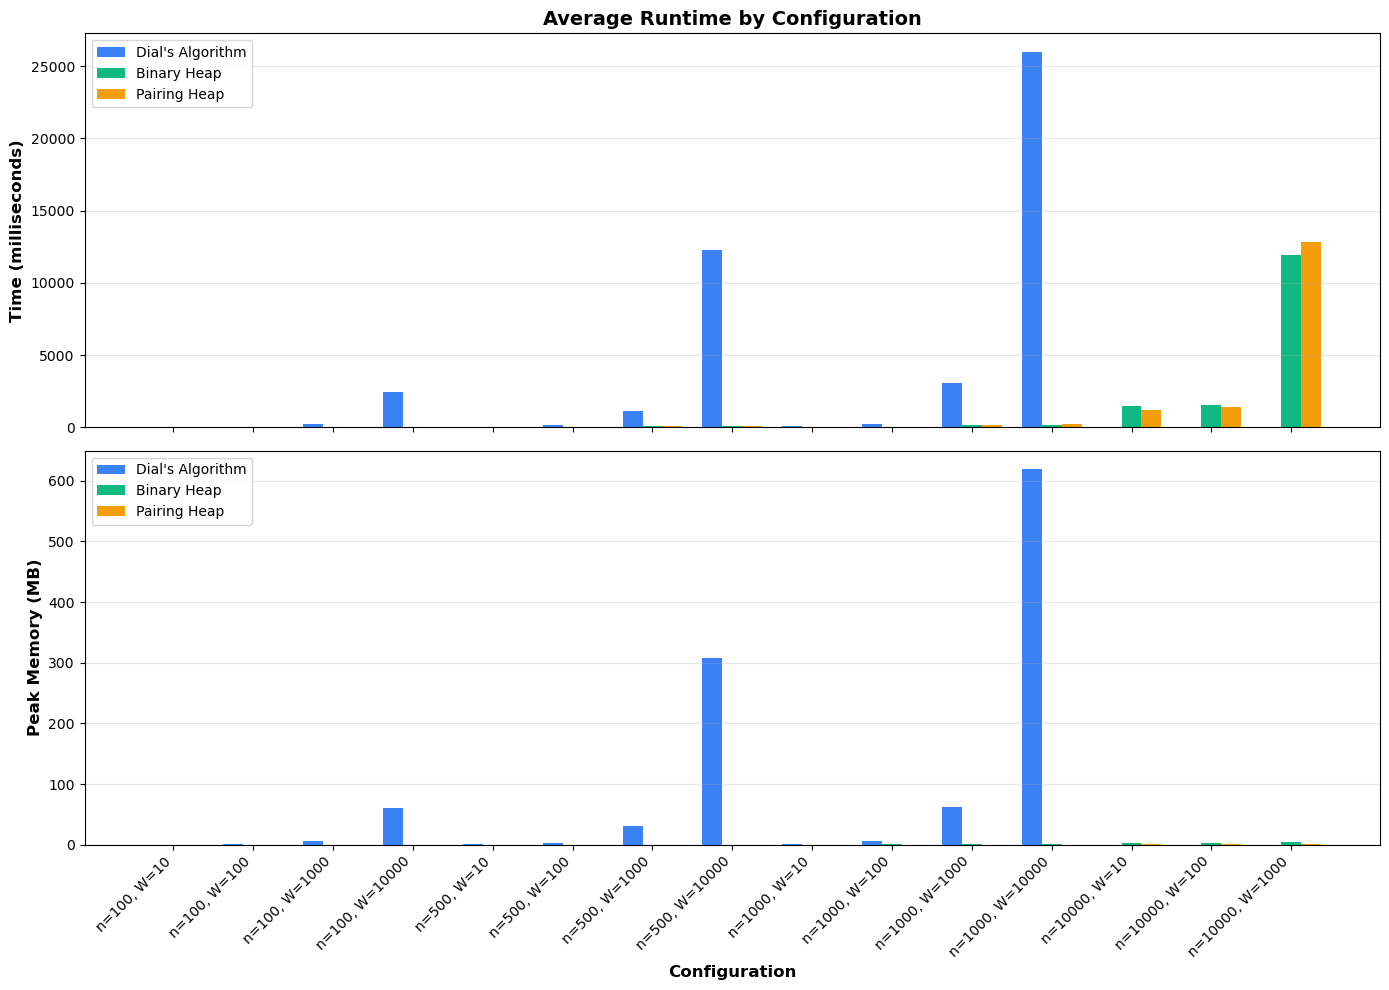

Saved: comparison_by_weight.png


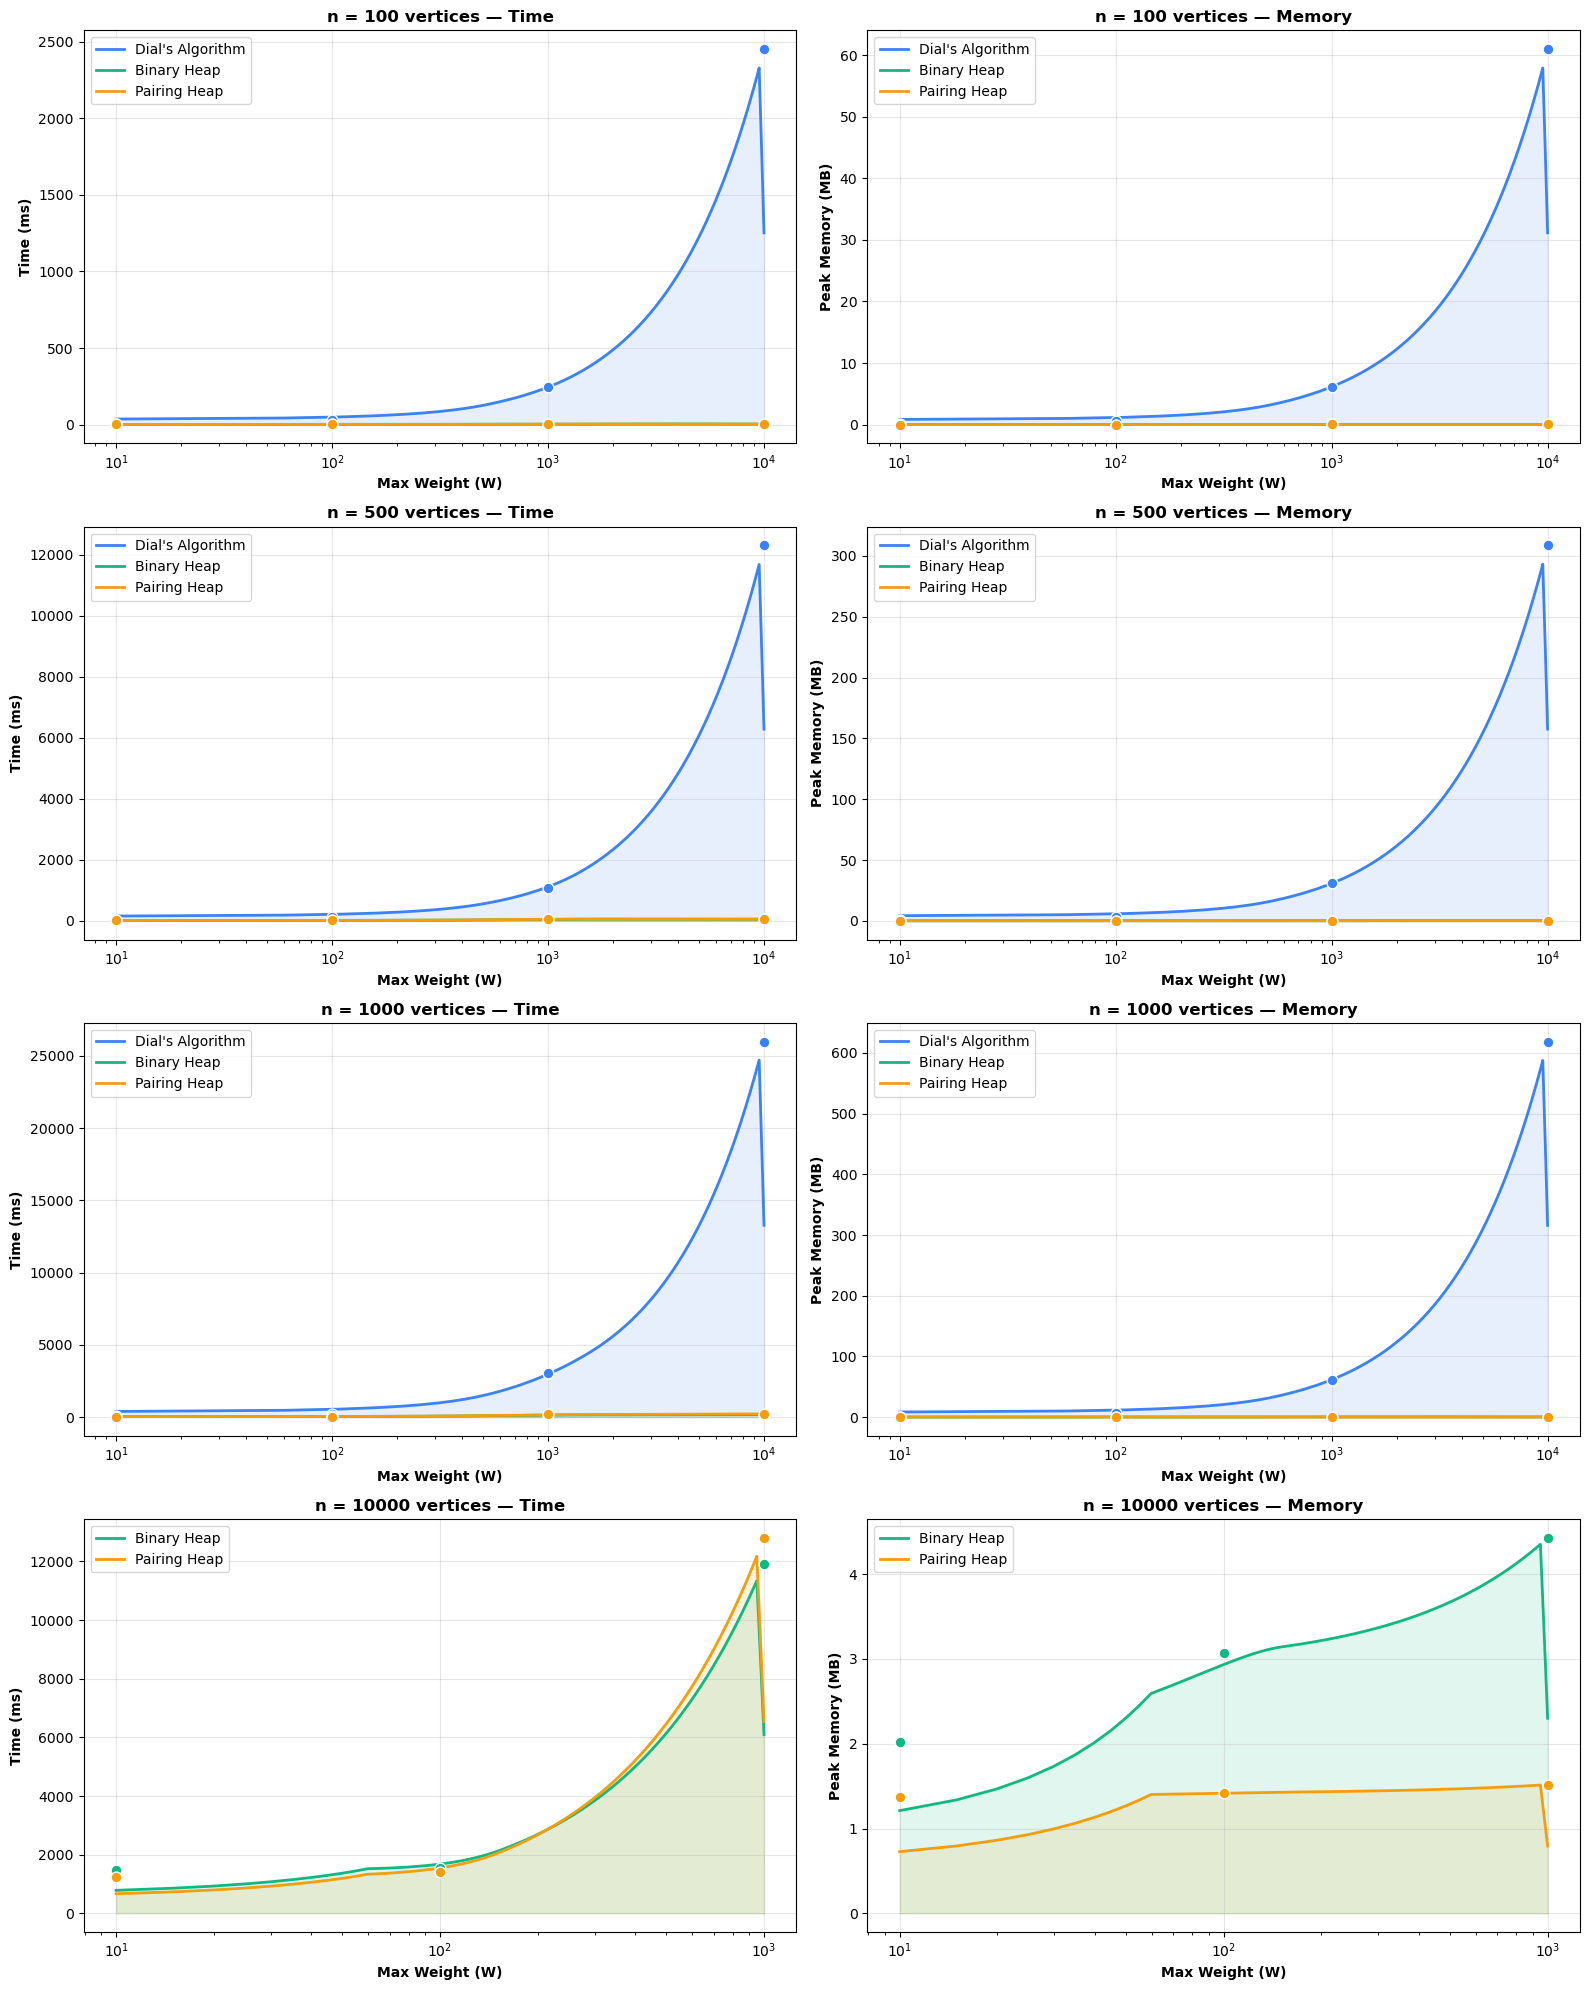

Saved: results.csv

Shortest paths to node 10:
  n=100, W=10: 0 -> 25 -> 10 (distance: 3.00)
  n=100, W=100: 0 -> 4 -> 60 -> 53 -> 80 -> 10 (distance: 33.00)
  n=100, W=1000: 0 -> 14 -> 75 -> 10 (distance: 204.00)
  n=100, W=10000: 0 -> 27 -> 10 (distance: 2075.00)
  n=500, W=10: 0 -> 183 -> 10 (distance: 3.00)
  n=500, W=100: 0 -> 148 -> 10 (distance: 11.00)
  n=500, W=1000: 0 -> 58 -> 85 -> 10 (distance: 60.00)
  n=500, W=10000: 0 -> 342 -> 424 -> 301 -> 10 (distance: 454.00)
  n=1000, W=10: 0 -> 213 -> 10 (distance: 2.00)
  n=1000, W=100: 0 -> 716 -> 637 -> 10 (distance: 5.00)
  n=1000, W=1000: 0 -> 658 -> 25 -> 177 -> 34 -> 10 (distance: 46.00)
  n=1000, W=10000: 0 -> 65 -> 827 -> 454 -> 680 -> 718 -> 10 (distance: 620.00)
  n=10000, W=10: 0 -> 2018 -> 10 (distance: 2.00)
  n=10000, W=100: 0 -> 5297 -> 817 -> 10 (distance: 3.00)
  n=10000, W=1000: 0 -> 3867 -> 5719 -> 1098 -> 444 -> 5978 -> 9729 -> 10 (distance: 12.00)

EXPERIMENT COMPLETE!
Generated files:
  1. comparison_bar_char

In [108]:
if __name__ == "__main__":
    random.seed(42)

    target_node = 10

    results = run_experiments(target=target_node)

    create_visualizations(results)

    export_csv(results)

    if target_node is not None and results.get('paths'):
        print()
        print(f"Shortest paths to node {target_node}:")
        for entry in results['paths']:
            if entry['path']:
                path_str = " -> ".join(str(node) for node in entry['path'])
                distance = entry['distance']
                distance_str = "inf" if distance == float('inf') else f"{distance:.2f}"
                print(f"  {entry['config']}: {path_str} (distance: {distance_str})")
            else:
                print(f"  {entry['config']}: unreachable")

    print()
    print("=" * 70)
    print("EXPERIMENT COMPLETE!")
    print("=" * 70)
    print("Generated files:")
    print("  1. comparison_bar_chart.png")
    print("  2. comparison_by_weight.png")
    print("  3. results.csv")


# Extra

In [109]:
# # ============= VISUALIZATION =============
# def create_visualizations(results):
#     print("Creating visualizations...")

#     # Extract data
#     configs = results['configs']
#     dial_times = [t for _, _, t in results['dial']]
#     binary_times = [t for _, _, t in results['binary']]
#     pairing_times = [t for _, _, t in results['pairing']]

#     # Plot 1: Bar chart comparison
#     fig, ax = plt.subplots(figsize=(14, 6))
#     x = np.arange(len(configs))
#     width = 0.25

#     ax.bar(x - width, dial_times, width, label="Dial's Algorithm", color='#3b82f6')
#     ax.bar(x, binary_times, width, label='Binary Heap', color='#10b981')
#     ax.bar(x + width, pairing_times, width, label='Pairing Heap', color='#f59e0b')

#     ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
#     ax.set_ylabel('Time (milliseconds)', fontsize=12, fontweight='bold')
#     ax.set_title('Dijkstra Algorithm Performance Comparison', fontsize=14, fontweight='bold')
#     ax.set_xticks(x)
#     ax.set_xticklabels(configs, rotation=45, ha='right')
#     ax.legend()
#     ax.grid(axis='y', alpha=0.3)

#     plt.tight_layout()
#     plt.savefig('comparison_bar_chart.png', dpi=300)
#     print("✓ Saved: comparison_bar_chart.png")

#     # Plot 2: Performance by weight range
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#     # Group by graph size
#     for idx, n_val in enumerate([100, 500, 1000]):
#         ax = axes[idx]

#         dial_data = [(w, t) for n, w, t in results['dial'] if n == n_val]
#         binary_data = [(w, t) for n, w, t in results['binary'] if n == n_val]
#         pairing_data = [(w, t) for n, w, t in results['pairing'] if n == n_val]

#         if dial_data:
#             weights = [w for w, _ in dial_data]
#             ax.plot(weights, [t for _, t in dial_data], marker='o', label="Dial's", linewidth=2)
#             ax.plot(weights, [t for _, t in binary_data], marker='s', label='Binary', linewidth=2)
#             ax.plot(weights, [t for _, t in pairing_data], marker='^', label='Pairing', linewidth=2)

#             ax.set_xlabel('Max Weight (W)', fontweight='bold')
#             ax.set_ylabel('Time (ms)', fontweight='bold')
#             ax.set_title(f'n = {n_val} vertices', fontweight='bold')
#             ax.legend()
#             ax.grid(True, alpha=0.3)
#             ax.set_xscale('log')

#     plt.tight_layout()
#     plt.savefig('comparison_by_weight.png', dpi=300)
#     print("✓ Saved: comparison_by_weight.png")

#     plt.show()
#     width = 0.25

#     ax.bar(x - width, dial_times, width, label="Dial's Algorithm", color='#3b82f6')
#     ax.bar(x, binary_times, width, label='Binary Heap', color='#10b981')
#     ax.bar(x + width, pairing_times, width, label='Pairing Heap', color='#f59e0b')

#     ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
#     ax.set_ylabel('Time (milliseconds)', fontsize=12, fontweight='bold')
#     ax.set_title('Dijkstra Algorithm Performance Comparison', fontsize=14, fontweight='bold')
#     ax.set_xticks(x)
#     ax.set_xticklabels(configs, rotation=45, ha='right')
#     ax.legend()
#     ax.grid(axis='y', alpha=0.3)

#     plt.tight_layout()
#     plt.savefig('comparison_bar_chart.png', dpi=300)
#     print("✓ Saved: comparison_bar_chart.png")

#     # Plot 2: Performance by weight range
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#     # Group by graph size
#     for idx, n_val in enumerate([100, 500, 1000]):
#         ax = axes[idx]

#         dial_data = [(w, t) for n, w, t in results['dial'] if n == n_val]
#         binary_data = [(w, t) for n, w, t in results['binary'] if n == n_val]
#         pairing_data = [(w, t) for n, w, t in results['pairing'] if n == n_val]

#         if dial_data:
#             weights = [w for w, _ in dial_data]
#             ax.plot(weights, [t for _, t in dial_data], marker='o', label="Dial's", linewidth=2)
#             ax.plot(weights, [t for _, t in binary_data], marker='s', label='Binary', linewidth=2)
#             ax.plot(weights, [t for _, t in pairing_data], marker='^', label='Pairing', linewidth=2)

#             ax.set_xlabel('Max Weight (W)', fontweight='bold')
#             ax.set_ylabel('Time (ms)', fontweight='bold')
#             ax.set_title(f'n = {n_val} vertices', fontweight='bold')
#             ax.legend()
#             ax.grid(True, alpha=0.3)
#             ax.set_xscale('log')

#     plt.tight_layout()
#     plt.savefig('comparison_by_weight.png', dpi=300)
#     print("✓ Saved: comparison_by_weight.png")

#     plt.show()